# DICOM Bounding Box

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
import pydicom as dicom
from scipy.ndimage import zoom
from collections import Counter

from matplotlib import animation
from IPython.display import HTML


from pathlib import Path
from med_seg.pipeline import *
from med_seg.data_input import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patches, patheffects

/home/vhl_ai/anaconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import h5py

In [4]:
PATH = Path('../../../ErikDL/fastai/data/CIT/')
TRAIN_DN = Path('scan-slice-128')

In [5]:
do = CITScanRetrieve(Path('../../../ErikDL/fastai/data/CIT/'))

In [6]:
study_names = sorted([i.name for i in list((PATH/'scans').iterdir()) if '.zip' not in i.name if '.ipynb' not in i.name])
study_names = do.filter_out_incompatible(study_names)

Cannot open CHU332
Cannot open CHU333
Cannot open CHU384
Cannot open CHU390
Cannot open CHU405
Cannot open CHU406
Cannot open CHU408
Cannot open CHU413_ms
Cannot open CHU421
Cannot open CHU428
Cannot open CHU443
Cannot open CHU445
Cannot open CHU447
Cannot open CHU450
Cannot open CHU452
Cannot open CHU481
Cannot open CHU488
Cannot open CHU494
Cannot open CHU500
Cannot open CHU556_2


In [7]:
n = 15
scan, mask = do.load_resize_scan(study_names[n], 128)

In [8]:
scan.shape, mask.shape

((128, 128, 128), (128, 128, 128))

### Create bounding boxes from DICOM masks

In [9]:
def bb_range(mask):
    mask_where = np.where(mask)
    low = A([np.min(i) for i in mask_where])[0]
    high = A([np.max(i) for i in mask_where])[0]
    return low, high

def bb_scan_mask(scan, mask):
    low, high = bb_range(mask)
    mask = mask[low:high, ...]
    scan = scan[low:high, ...]
    return scan, mask

def slice_bb_coords(mask, pad = 0):
    bbx = np.zeros((len(mask), 4))
    for i in range(0, len(mask)):
        where = np.where(mask[i])
        bb_1 = A([np.min(i) for i in where])
        bb_2 = A([np.max(i) for i in where])
        bb_coords = np.array([bb_1[1]-pad, bb_1[0]-pad, bb_2[1]+pad, bb_2[0]+pad])
        bbx[i] = bb_coords
    return bbx

In [20]:
def concat_bb_scans_masks(study_names, sz=128):
    scans = []
    masks = []
    for i in study_names:
        scan = np.load(PATH/f'scan-crop-{sz}'/f'{i}.npy')
        mask = np.load(PATH/f'mask-crop-{sz}'/f'{i}.npy') 
        bb_scan, bb_mask = bb_scan_mask(scan, mask)
        scans = scans+[bb_scan]
        masks = masks+[bb_mask]
    scans = np.concatenate(scans, axis=0)[:,None,:,:]
    masks = np.concatenate(masks, axis=0)
    return scans, masks

def slice_bb_coords(study_names, sz=128, pad = 0):
    scans, masks = concat_bb_scans_masks(study_names, sz)
    bbx = np.zeros((len(masks), 4))
    for i in range(0, len(masks)):
        where = np.where(masks[i])
        bb_1 = A([np.min(i) for i in where])
        bb_2 = A([np.max(i) for i in where])
        bb_coords = np.array([bb_1[1]-pad, bb_1[0]-pad, bb_2[1]+pad, bb_2[0]+pad])
        bbx[i] = bb_coords
    
    return scans, masks, bbx

In [21]:
all_scans, all_masks, all_bbox = slice_bb_coords(study_names)
all_scans.shape, all_masks.shape, all_bbox.shape

((9535, 1, 128, 128), (9535, 128, 128), (9535, 4))

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
frames = []
for i in range(0, 9534, 100):
    im = plt.imshow(all_masks[i,...])
    b = all_bbox[i]
    box = patches.Rectangle(b[:2], b[-2]-b[0], b[-1]-b[1], linewidth=1,
                          edgecolor='r', facecolor='none')
    ax.add_patch(box)
    frames.append([im, box])
    

plt.close(fig)

ani = animation.ArtistAnimation(fig,frames,interval=100, blit=True,repeat_delay=1000)
HTML(ani.to_jshtml(default_mode="reflect"))

### Convert data to csv and .jpg for training

In [33]:
def save_scan_slices(path, scans):
    scan_ids = []
    for i in range(0, len(scans)):
        scan = scans[i]
        scan = np.repeat(np.swapaxes(np.swapaxes(scan, 0, -1), -0, -2), 3, -1)
        scipy.misc.imsave(path/'scan-slice-128'/f'{i}.jpg', scan)
        idx = str(i)+'.jpg'
        scan_ids = scan_ids+[idx]
    return scan_ids

def save_mask_slices(path, masks):
    mask_ids = []
    for i in range(0, len(masks)):
        mask = masks[i]
        scipy.misc.imsave(path/'mask-slice-128'/f'{i}.jpg', mask)
        idx = str(i)+'.jpg'
        mask_ids = mask_ids+[idx]
    return mask_ids

In [34]:
(PATH/'tmp').mkdir(exist_ok=True)
BB_CSV = PATH/'tmp/bb.csv'

In [ ]:
# scan_ids = save_scan_slices(PATH, all_scans)

In [ ]:
# mask_ids = save_mask_slices(PATH, all_masks)

In [ ]:
# all_bbs = [' '.join(str(int(p)) for p in o) for o in all_bbox]
# len(all_bbs)

In [ ]:
# df = pd.DataFrame({'scan id': [scan_ids[o] for o in range(0, len(scan_ids))],
#                   'bb': [all_bbs[o] for o in  range(0, len(all_bbs))]},
#                  columns=['scan id', 'bb'])

In [ ]:
# df.to_csv(BB_CSV, index=False)

In [25]:
BB_CSV.open().readlines()[0:5]

['scan id,bb\n',
 '0.jpg,70 88 80 95\n',
 '1.jpg,68 79 97 96\n',
 '2.jpg,64 66 98 97\n',
 '3.jpg,61 64 99 98\n']

In [27]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, gt=False):
    if (gt==False):
        patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='red', lw=1))
        draw_outline(patch, 4)
    else:
        patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=1))
        draw_outline(patch, 4)

In [28]:
##Define train/val split and determine stats for tfms
# split_idx = int(len(all_scans)*0.80)

# stats = [[all_scans.mean()],[all_scans.std()]]

# stats

In [35]:
sz=128
bs=128
stats = [[-302.81140580597673], [410.7512185618356]]

augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(10, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=None)

In [36]:
val_idxs = list(range(1907))
md = ImageClassifierData.from_csv(PATH, TRAIN_DN, BB_CSV, num_workers=16, tfms=tfms, val_idxs=val_idxs, continuous=True, bs=bs)                  
denorm = md.trn_ds.denorm

In [37]:
train_iter = iter(md.trn_dl)

In [38]:
x,y = next(train_iter)
x.shape, y.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 4]))

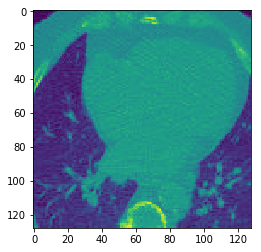

In [43]:
show_img(x[0,0,...])

[41. 39. 32. 36.]
[57. 46. 12.  9.]
[25. 27. 68. 66.]
[26. 26. 70. 74.]
[36. 36. 37. 35.]
[39. 36. 43. 41.]
[51. 32. 39. 65.]
[29. 31. 70. 67.]
[34. 30. 49. 44.]


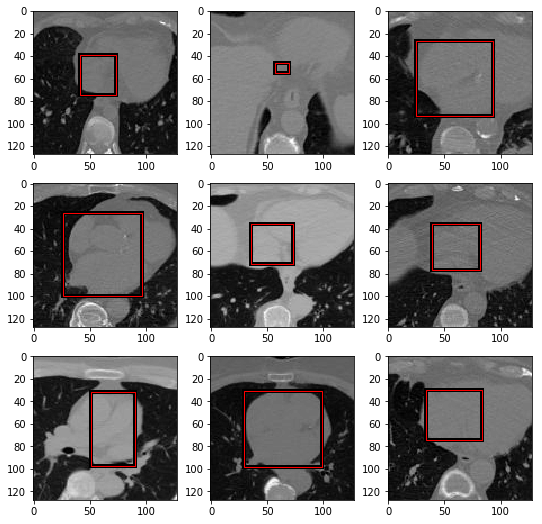

In [46]:
#Check data before training
idx=4
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.trn_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

### Build Model

In [47]:
f_model = resnet34

In [48]:
## Use model summary to determine input size for custom head
# regression = nn.Sequential(Flatten())
# learn = ConvLearner.pretrained(f_model, md, custom_head=regression)
# learn.summary()

In [49]:
reg_head = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(8192,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4)
)

In [50]:
learn = ConvLearner.pretrained(f_model, md, custom_head=reg_head)
learn.opt_fn = optim.Adam
learn.crit = nn.SmoothL1Loss()

HBox(children=(IntProgress(value=0, description='Epoch: ', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      65.044706  3518.917179



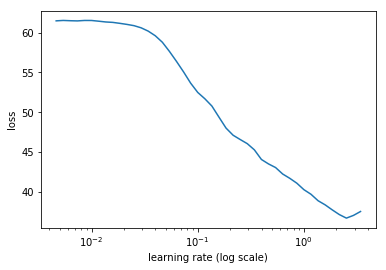

In [52]:
learn.lr_find(10e-4)
learn.sched.plot()

In [53]:
lr = 50e-2
lrs = np.array([lr/1000, lr/100, lr/10])
wd=1e-7

In [54]:
learn.fit(lr,1,wds=wd,cycle_len=4,use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch: ', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      15.676643  7.292052  
    1      10.729222  10.045511                           
    2      9.685252   7.420997                            
    3      8.689424   7.275655                            



[7.2756554366533335]

In [55]:
learn.freeze_to(-2)

In [56]:
learn.fit(lrs/5,1,wds=wd,cycle_len=5,use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch: ', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      6.783383   226.882606
    1      6.045659   136.444373                          
    2      5.6486     992.676669                          
    3      5.398221   38.352629                           
    4      5.195219   6.684128                            



[6.684127898383778]

In [57]:
learn.unfreeze()

In [58]:
learn.fit(lrs/20,1,wds=wd,cycle_len=50,use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch: ', max=50), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      5.810267   19.933804 
    1      5.464396   7.096743                            
    2      5.253983   7.120991                            
    3      5.129768   7.3656                              
    4      5.097562   16.628107                           
    5      5.036838   6.457941                            
    6      4.96578    7.357685                            
    7      4.943496   6.121424                            
    8      4.871711   10.111185                           
    9      4.794426   5.873037                            
    10     4.770806   21.396644                           
    11     4.728766   6.912082                            
    12     4.740124   20.39902                            
    13     4.691396   27.417784                           
    14     4.691017   5.852466                            
    15     4.645032   5.516042                            
    16     4.569837   9

[4.056794755922667]

In [59]:
learn.fit(lrs/20,1,wds=wd,cycle_len=50,use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch: ', max=50), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      3.900122   5.854207  
    1      3.947946   4.393993                            
    2      4.046159   21.414449                           
    3      4.063345   21.120566                           
    4      4.09203    5.936579                            
    5      4.104016   18.953156                           
    6      4.177973   15.61673                            
    7      4.198603   6.459511                            
    8      4.136397   25.006069                           
    9      4.102515   44.741867                           
    10     4.051011   16.188886                           
    11     4.025462   15.359075                           
    12     4.037938   6.768028                            
    13     3.982582   17.35629                            
    14     3.965462   30.249113                           
    15     3.895625   33.045464                           
    16     3.879644   2

[3.8637731904188377]

In [ ]:
learn.save('CIT_BB_One_SL1')

In [60]:
data_iter = iter(md.val_dl)

In [66]:
x,y = next(data_iter)
learn.model.eval()
preds = to_np(learn.model(V(x)))

6.3263264
6.3882065
10.569717
6.3133087
7.5599785
7.912529
4.977337
3.1667538
6.5465336
4.1647453
3.1903248
5.5302963


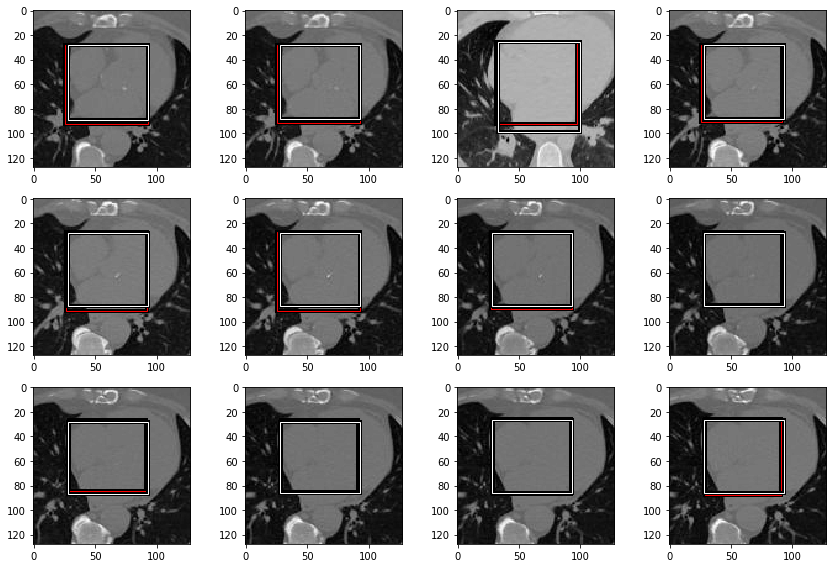

In [67]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    L1Loss = np.sum(np.abs(preds[i] - np.array(y[i])), axis=0)
    print(L1Loss)
    y_rect = bb_hw(np.array(y[i]))
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_rect(ax, y_rect, gt=True)
plt.tight_layout()